# Starter Notebook

Install and import required libraries

In [1]:
# !pip install transformers datasets evaluate accelerate peft trl bitsandbytes
# !pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# !pip install pandas

In [1]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
import torch.nn.functional as F

/home/ns6287/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Tokenizer and Preprocess Data

In [2]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [3]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {v: k for k, v in id2label.items()}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [4]:
# Load teacher model (frozen)
teacher_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-large", num_labels=4, id2label=id2label, label2id=label2id
).eval().cuda()
for param in teacher_model.parameters():
    param.requires_grad = False

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Load student model with LoRA
student_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=4, id2label=id2label, label2id=label2id
)

lora_config = LoraConfig(
    r=4,  # increased capacity
    lora_alpha=32,
    lora_dropout=0.2,
    bias="none",
    target_modules=["query", "key", "value"],  # add key for better attention learning
    task_type="SEQ_CLS"
)
student_model = get_peft_model(student_model, lora_config)
student_model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495


## Anything from here on can be modified

In [19]:
# Custom loss with distillation
class DistillTrainer(Trainer):
    label_names=["labels"]
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        TEMPERATURE = 4.0
        input_ids = inputs["input_ids"].to(model.device)
        attention_mask = inputs["attention_mask"].to(model.device)
        labels = inputs["labels"].to(model.device)

        # Teacher forward pass
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
            teacher_logits = teacher_outputs.logits

        # Student forward pass
        student_outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        ce_loss = F.cross_entropy(student_logits, labels)
        kl_loss = F.kl_div(
            F.log_softmax(student_logits / TEMPERATURE, dim=-1),
            F.softmax(teacher_logits / TEMPERATURE, dim=-1),
            reduction="batchmean"
        ) * (TEMPERATURE ** 2)
        
        loss = 0.7 * ce_loss + 0.3 * kl_loss
        return (loss, student_outputs) if return_outputs else loss

In [20]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

In [21]:
print("Eval Dataset Number of Entries: ", eval_dataset.num_rows)
print("Train Dataset Number of Entries: ", train_dataset.num_rows)

Eval Dataset Number of Entries:  640
Train Dataset Number of Entries:  119360


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [22]:
print("Trainable parameters:")
for name, param in student_model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.key.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.key.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.

In [23]:
print('PEFT Model')
student_model.print_trainable_parameters()

PEFT Model
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495


## Training Setup

In [24]:
# !pip install scikit-learn

In [25]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [26]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    logging_steps=100,
    learning_rate=5e-5,
    num_train_epochs=5,
    # max_steps=1200,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    weight_decay=0.01,
    gradient_checkpointing=True,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

def get_trainer(model):
      return DistillTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}
)

### Start Training

In [28]:
peft_lora_finetuning_trainer = get_trainer(student_model)

result = peft_lora_finetuning_trainer.train()

/tmp/ipykernel_5408/1774179807.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillTrainer.__init__`. Use `processing_class` instead.
  return DistillTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
100,0.974200,0.969576,0.246875
200,0.970400,0.968410,0.265625
300,0.967600,0.966695,0.356250
400,0.966200,0.964279,0.389062
500,0.962400,0.961327,0.326562
600,0.959900,0.958593,0.459375
700,0.955300,0.952538,0.559375
800,0.951300,0.949331,0.528125
900,0.942700,0.941707,0.706250
1000,0.937300,0.936105,0.581250


/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_g

KeyboardInterrupt: 

In [29]:
# Phase 2 training
trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}
)
trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
100,0.585000,0.542782,0.889062
200,0.614100,0.540007,0.885938
300,0.602500,0.537989,0.889062
400,0.582600,0.535303,0.890625
500,0.585700,0.530369,0.890625
600,0.589400,0.527552,0.895312
700,0.591300,0.521631,0.890625
800,0.597500,0.519293,0.892188
900,0.552400,0.509406,0.893750
1000,0.552000,0.502660,0.892188


/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_g

KeyboardInterrupt: 

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [30]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [31]:
classify( student_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( student_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 0, Label: World, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [32]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [33]:
# Check evaluation accuracy
_, _ = evaluate_model(student_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:03<00:00, 20.69it/s]

Evaluation Metric: {'accuracy': 0.89375}


### Run Inference on unlabelled dataset

In [34]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:05<00:00, 1410.13 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [35]:
# Run inference and save predictions
preds = evaluate_model(student_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:35<00:00, 28.14it/s]

Inference complete. Predictions saved to inference_output.csv


### Confusion Matrix

In [36]:
# !pip install matplotlib

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [38]:
def show_confusion_matrix(model, dataset, tokenizer, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    true_labels = []
    pred_labels = []

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

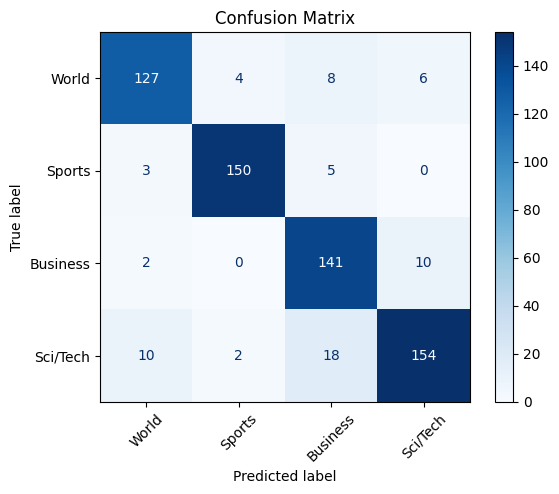

In [39]:
show_confusion_matrix(student_model, eval_dataset, tokenizer)